# **Otimização Trajeto - RJ**
### Aplicação do modelo *TSP*
###### Autor: Fernando Söndahl Brito

 ##  **1. Contexto**

> O objetivo desse trabalho é gerar um modelo de otimização para o caso *TSP*. Como base, foram utilizadas as coordenadas dos municípios do estado do Rio de Janeiro e tendo como produto a rota que minimiza as distâncias euclidianas do percurso.

### Motivação

<img src="https://github.com/fersondahl/roterizacao/blob/main/Motiva%C3%A7%C3%A3o.png?raw=true" alt="drawing" width="800"/>


##  **2. Pacotes e bibliotecas**

In [ ]:
!pip install geopandas
!pip install pyomo
!apt-get install -y -qq glpk-utils
!pip install haversine

In [8]:
import time
import os

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from haversine import haversine, Unit, haversine_vector
import pyomo.environ as pyo
from pyomo.environ import *
from pyomo.opt import SolverFactory
import geopandas

import shapely
from shapely.geometry import Point, LineString
from shapely.geometry.polygon import Polygon


## **3. Dados do problema**
> Coleta das coordenadas e tabela De Para com o cálculo combinatótio das distâncias entre os nós (municípios).

In [9]:
rj = geopandas.read_file(r"https://github.com/fersondahl-uff/TCC/raw/main/Camada%20RJ.GEOJSON")[["NOME", "geometry"]]

rj['ponto_representativo'] = rj['geometry'].apply(lambda linha: linha.representative_point())
rj['Longitude'] = rj['ponto_representativo'].apply(lambda linha: linha.coords[0][0])
rj['Latitude'] = rj['ponto_representativo'].apply(lambda linha: linha.coords[0][1])

dic_comb = {'origem': [], 'destino': [], 'loc_orig': [], 'loc_dest': []}

geo_df = rj.copy()
geo_df['cords'] = geo_df['Latitude'].astype(str) + ", " + geo_df['Longitude'].astype(str)
geo_df['chave'] = geo_df.index

for i in range(len(geo_df)):
    for j in range(len(geo_df)):
        dic_comb['origem'].append(geo_df['chave'][i])
        dic_comb['destino'].append(geo_df['chave'][j])
        dic_comb['loc_orig'].append(geo_df['cords'][i])
        dic_comb['loc_dest'].append(geo_df['cords'][j])

#### dist - DataFrame de combinação de todas as distâncias das coordenadas entre si

dist_df = pd.DataFrame(data=dic_comb)

for col in['loc_orig', 'loc_dest']:
  dist_df[col] = dist_df[col].apply(lambda lin: tuple((list(map(float, lin.split(','))))))

dist_df['Distancia'] = haversine_vector(list(dist_df['loc_orig']), list(dist_df['loc_dest'])).astype(float)


matriz_de_para = dist_df.pivot(values='Distancia', index='origem', columns='destino')

## **4. Modelo de Otimização**
> Modelagem do problema a partir de programação linear inteira. Foi utilizada a formulação DFJ para inibir o sub-roteamento e adotou-se o método de *lazy constraints* para a não explosão exponencial do problema.
A cada iteração, são verificadas as sub-rotas contidas na solução e são adicionadas restrições para impedi-las. As iterações findam quando a solução  encontra apenas um ciclo ligando todos os nós.

In [40]:
# Instanciação do modelo e solução inicial

model = pyo.ConcreteModel()


model.vertice = pyo.Var(range(len(matriz_de_para)), range(len(matriz_de_para)), bounds=(0, 1), within=Integers)
vertice = model.vertice


model.C1 = pyo.ConstraintList()
for i in range(len(matriz_de_para)):
    model.C1.add(expr= sum(vertice[i, j] for j in range(len(matriz_de_para))) == 1)  # Restrição [2]
    model.C1.add(expr= sum(vertice[j, i] for j in range(len(matriz_de_para))) == 1) # Restrição [3]

model.C2 = pyo.ConstraintList()
for i in range(len(matriz_de_para)):
    model.C2.add(expr= vertice[i, i] ==0)    #Imperdir nó de sair e chegar em si próprio

model.restS = pyo.ConstraintList()

model.obj = pyo.Objective(expr= sum(vertice[i, j]*matriz_de_para[i][j] for i in range(
                                len(geo_df)) for j in range(len(geo_df))), sense=minimize) # Restrição [6]

opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
opt.solve(model)

result = []
resultado = []

vet_mult = list(range(len(matriz_de_para)))
for i in range(len(matriz_de_para)):
    resultado.append(int(sum(pyo.value(vertice[i,j])*vet_mult[j] for j in range(len(matriz_de_para)))))

geo_df['Destino_inic'] = resultado


In [41]:
# Solução iterativa do modelo - contenção dos subciclos
ciclo = []
subrotas = []
subciclo = []

durac = time.time()

n_iter = 1
model.restS.clear()
while len(ciclo) != len(geo_df):

    for s in subciclo:
        model.restS.add(expr =sum(vertice[i, j] for i in s for j in s) - len(s) <=  -1)

    print(f"{n_iter}ª iteração: {len(model.restS)} restrições DFJ.")

    opt = SolverFactory('glpk', executable='/usr/bin/glpsol')
    opt.solve(model)

    result = []
    resultado = []

    vet_mult = list(range(len(matriz_de_para)))
    for i in range(len(matriz_de_para)):
        resultado.append(int(sum(pyo.value(vertice[i,j])*vet_mult[j] for j in range(len(matriz_de_para)))))

    geo_df['Destino'] = resultado

    ciclo = [geo_df['chave'][0]]
    subrotas = []
    arestas = []
    j=0

    control = ''

    while control != 'done':

        for i in range(len(geo_df)):
            ciclo.append(geo_df['Destino'][j])
            arestas.append(geo_df['Destino'][j])
            j=geo_df['Destino'][j]

        ciclo = list(dict.fromkeys(ciclo))

        subrotas.append(ciclo)
        arest_tot = sum(list(map(lambda elemento: len(elemento), subrotas)))
        dif = list(set(arestas).symmetric_difference(set(list(geo_df['chave']))))
        try:
            j = dif[0]
            ciclo = [dif[0]]
        except IndexError:
            control = 'done'

    subciclo +=subrotas

    n_iter +=1

print(f'Otimização concluída em {round(time.time() - durac, 2)} segundos\nDistância total: {round(pyo.value(model.obj), 2)}')


1ª iteração: 0 restrições DFJ.
2ª iteração: 42 restrições DFJ.
3ª iteração: 98 restrições DFJ.
4ª iteração: 160 restrições DFJ.
5ª iteração: 230 restrições DFJ.
6ª iteração: 303 restrições DFJ.
7ª iteração: 380 restrições DFJ.
8ª iteração: 461 restrições DFJ.
9ª iteração: 544 restrições DFJ.
Otimização concluída em 13.44 segundos
Distância total: 1823.44


## **5. Resultado**
> Solução inicial com a formação dos Sub-ciclos:

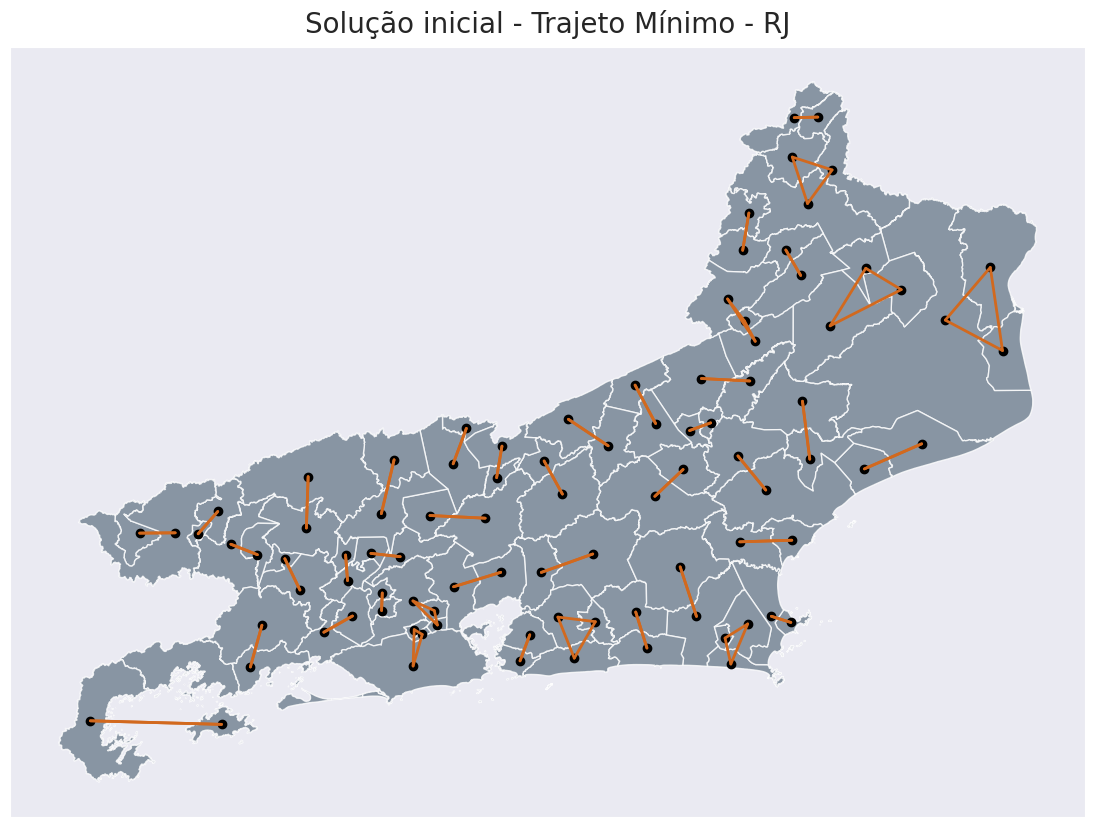

In [52]:
#### mapa dos trajetos
def plots(soluc: str, title: str):
  trajetos_df = geo_df[['chave', 'Latitude', 'Longitude', soluc]].rename(
      columns={'chave': 'Origem'})

  trajetos_df = pd.merge(left=trajetos_df, right=geo_df[['Longitude', 'Latitude']], left_on=soluc, right_index=True, how='left')


  with sns.axes_style('dark'):
      # Plotagem do mapa

      fig, ax = plt.subplots()
      # Layer RJ
      rj.plot(ax=ax, alpha=0.8,color='slategrey')
      # Coordenadas dos serviços
      plt.plot(list(geo_df['Longitude']), list(geo_df['Latitude']), 'ko')

      # Trajetos
      for i in range(len(trajetos_df)):
          a = [trajetos_df["Longitude_x"][i], trajetos_df["Longitude_y"][i]]
          b = [trajetos_df["Latitude_x"][i], trajetos_df["Latitude_y"][i]]
          plt.plot(a,b, linewidth = 2, linestyle = "-", color = "chocolate")

      plt.title(title, fontdict={'fontsize': 20, 'horizontalalignment': 'center','verticalalignment': 'bottom'})
      plt.xticks(ticks=[])
      plt.yticks(ticks=[])

      fig.set_figheight(10, forward=True)
      fig.set_figwidth(15, forward=True)

plots("Destino_inic", "Solução inicial - Trajeto Mínimo - RJ")

> Solução final com os Sub-ciclos tratados:

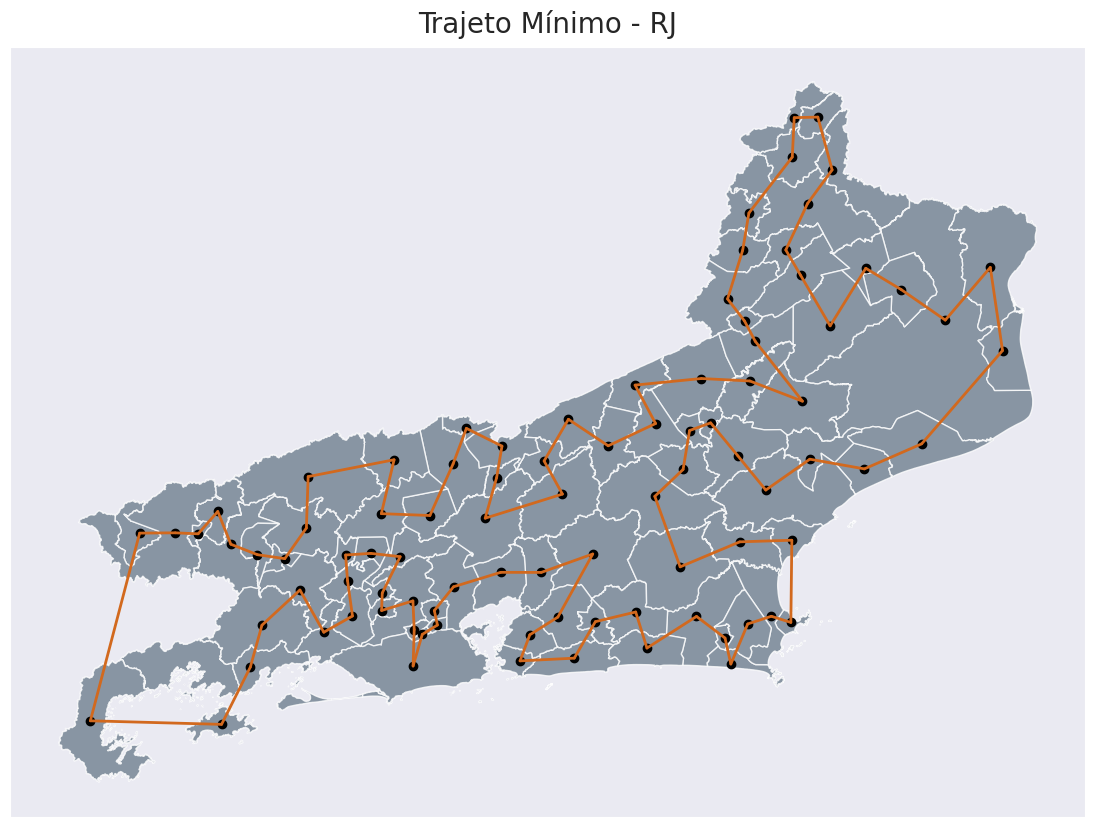

In [49]:
plots("Destino", "Trajeto Mínimo - RJ")